<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/main/start_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



In the cell below we import the required libraries for our project



---



In [1]:


import tensorflow
import pandas as pd
import time
import numpy as np
import statistics

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt





---



# Read Data



---



In [2]:


df = pd.read_csv('./features_30_sec.csv')



In [3]:


df['label'].value_counts()



blues        100
jazz         100
hiphop       100
pop          100
classical    100
reggae       100
metal        100
country      100
rock         100
disco        100
Name: label, dtype: int64

#Question 1




---



In the cell below, we pre-process the data and split the data into train and test 



---



In [4]:


columns_to_drop = ['label','filename', 'length']

def prepare_dataset_question1(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # divide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test



In [5]:


# Splitting the data into train and test with a 70:30 split
X_train, y_train, X_test, y_test = prepare_dataset_question1(df, columns_to_drop, test_size=0.3, random_state=0)





---





Creating functions to build and train models

1. build_model - This function accepts parameters including total_classes , input_shape , hidden_layer_neurons , hidden_layers (denotes total number of hidden layers in the model architecture) , need_drop_out (denotes if the dropout layer needs to be added in the architecture , dropout_probability , optimizer . This function declares the model architecture as well as compiles it and returns the model

2. train_model - This function accepts parameters including the keras model, epochs , X_train , y_train , X_test , y_test , batch_size , callbacks. This function essentially fits the model on the training data and tests it on the test data and returns the history denoting the results of the model





---



In [6]:


def build_model(total_classes,input_shape,hidden_layer_neurons=16,hidden_layers=1,need_drop_out=True,dropout_probability=0.3,optimizer='adam'):

  model=tf.keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))

  for i in range(hidden_layers):
    model.add(keras.layers.Dense(hidden_layer_neurons, activation="relu"))

    if(need_drop_out):
      model.add(keras.layers.Dropout(dropout_probability))

  model.add(keras.layers.Dense(total_classes, activation='softmax'))
  model.compile(optimizer=optimizer,metrics=['accuracy'],loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

def train_model(model,epochs,X_train,y_train,X_test,y_test,batch_size=1,callbacks=[]):

  history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),callbacks=callbacks)
  return history



#Question 1 Part a) 


In [7]:


history={}
model=build_model(10,X_train[0].shape)
history['question-1']=train_model(model,50,X_train,y_train,X_test,y_test)



Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


700/700 [==============================] - 2s 2ms/step - loss: 2.2477 - accuracy: 0.2286 - val_loss: 1.8182 - val_accuracy: 0.3567
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.7704 - accuracy: 0.3729 - val_loss: 1.5262 - val_accuracy: 0.4567
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.5002 - accuracy: 0.4471 - val_loss: 1.3537 - val_accuracy: 0.4867
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 1.3287 - accuracy: 0.5086 - val_loss: 1.2575 - val_accuracy: 0.5067
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 1.2627 - accuracy: 0.5443 - val_loss: 1.1781 - val_accuracy: 0.5700
Epoch 6/50
700/700 [==============================] - 1s 2ms/step - loss: 1.1731 - accuracy: 0.5686 - val_loss: 1.1400 - val_accuracy: 0.5800
Epoch 7/50
700/700 [==============================] - 1s 2ms/step - loss: 1.1208 - accuracy: 0.5900 - val_loss: 1.0968 - val_accuracy: 0.6000
Epoch 8/50
700/70

#Question 1 Part b)

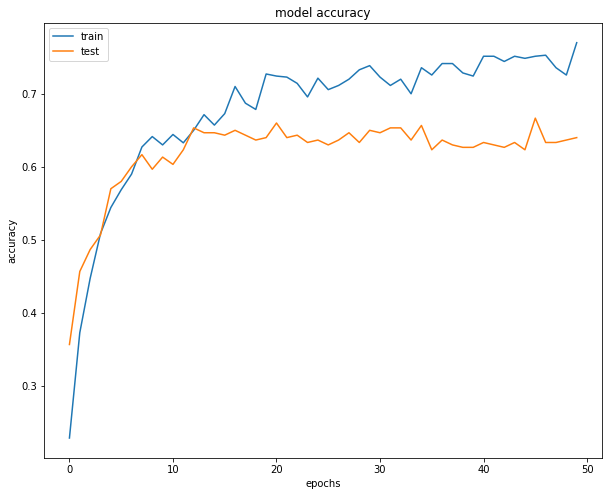

In [16]:


# summarize history for accuracy
plt.figure(figsize = (10,8))
plt.plot(history['question-1'].history['accuracy'])
plt.plot(history['question-1'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#Question 1 c)

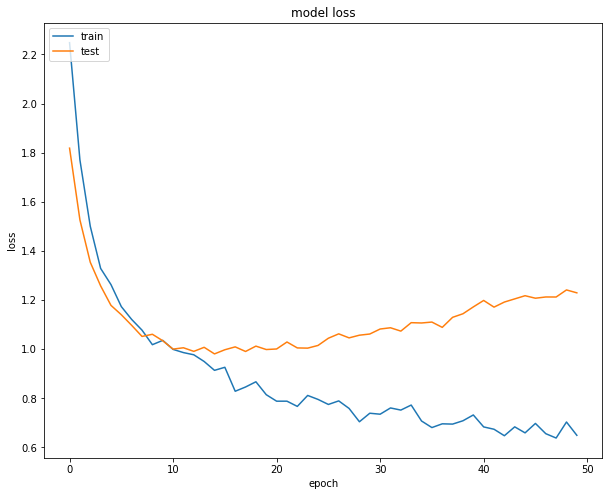

In [17]:


# summarize history for loss
plt.figure(figsize = (10,8))
plt.plot(history['question-1'].history['loss'])
plt.plot(history['question-1'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Question 2



---



In the cell below, we add a callback to find spoch times during training



---



In [18]:


class TimeHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)





---



In the cell below, we create models for different batch-sizes over 3 fold cross validation



---



In [19]:


n_splits=3 # total number of folds in the cross-validation

kf = KFold(n_splits=n_splits) # creating KFold object 

batch_sizes=[1,4,8,16,32,64] # batch_sizes list denotes the search space of the batch sizes given in the assignment handout

total_classes=10 # denotes total number of classes

input_shape=X_train[0].shape # denotes input shape

history={} # denotes a history dictionary to save the results of the trained model

k_fold=1 # denotes the current k_fold during the experiment 

epochs=50 # denotes total epochs

epoch_times={} # denotes a dictionary to save the epoch times during cross-validation to find median epoch times later

for element in batch_sizes:

  for fold in range(1,4):
    epoch_times[(element,fold)]=[]

for train,test in kf.split(X_train):

  X_train_cross_validation , X_test_cross_validation = X_train[train] , X_train[test]
  y_train_cross_validation , y_test_cross_validation = y_train[train] , y_train[test]

  for batch_size in batch_sizes:

    print()
    print('Model for batch size ',batch_size, ' and fold ',k_fold)

    tf.keras.backend.clear_session()
    model=build_model(total_classes,input_shape)
    time_callback = TimeHistory()
    history[(batch_size,k_fold)] = train_model(model,epochs,X_train_cross_validation,y_train_cross_validation,X_test_cross_validation,y_test_cross_validation,batch_size,[time_callback])
    
    for element in time_callback.times: # this for-loop code is used to save epoch_times for the respective batch_size and k_fold pair
      epoch_times[(batch_size,k_fold)].append(element)

  k_fold+=1




Model for batch size  1  and fold  1
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


466/466 [==============================] - 1s 2ms/step - loss: 2.3236 - accuracy: 0.2189 - val_loss: 1.8927 - val_accuracy: 0.3761
Epoch 2/50
466/466 [==============================] - 1s 2ms/step - loss: 1.8640 - accuracy: 0.3541 - val_loss: 1.6245 - val_accuracy: 0.4145
Epoch 3/50
466/466 [==============================] - 1s 2ms/step - loss: 1.5759 - accuracy: 0.4313 - val_loss: 1.4629 - val_accuracy: 0.5128
Epoch 4/50
466/466 [==============================] - 1s 2ms/step - loss: 1.4352 - accuracy: 0.4936 - val_loss: 1.3378 - val_accuracy: 0.5598
Epoch 5/50
466/466 [==============================] - 1s 2ms/step - loss: 1.3436 - accuracy: 0.5365 - val_loss: 1.2757 - val_accuracy: 0.5427
Epoch 6/50
466/466 [==============================] - 1s 2ms/step - loss: 1.2989 - accuracy: 0.5236 - val_loss: 1.2344 - val_accuracy: 0.5983
Epoch 7/50
466/466 [==============================] - 1s 2ms/step - loss: 1.2144 - accuracy: 0.5386 - val_loss: 1.2062 - val_accuracy: 0.5940
Epoch 8/50
466/46



---



In the cell below ,we calculate the mean cross validation accuracies over 3 folds for the respective batch sizes



---



In [20]:


mean_cross_validation_accuracies=[]

for batch_size in batch_sizes:
  temp=[]

  for k_fold in range(1,4):
    temp.append(history[batch_size,k_fold].history['val_accuracy'])

  mean_accuracy=[0]*epochs

  for list1 in temp:

    for epoch in range(len(list1)):
      mean_accuracy[epoch]+=list1[epoch]
  
  for i in range(epochs):
    mean_accuracy[i]=mean_accuracy[i]/3
    
  mean_cross_validation_accuracies.append(mean_accuracy.copy())


#Question 2 a)

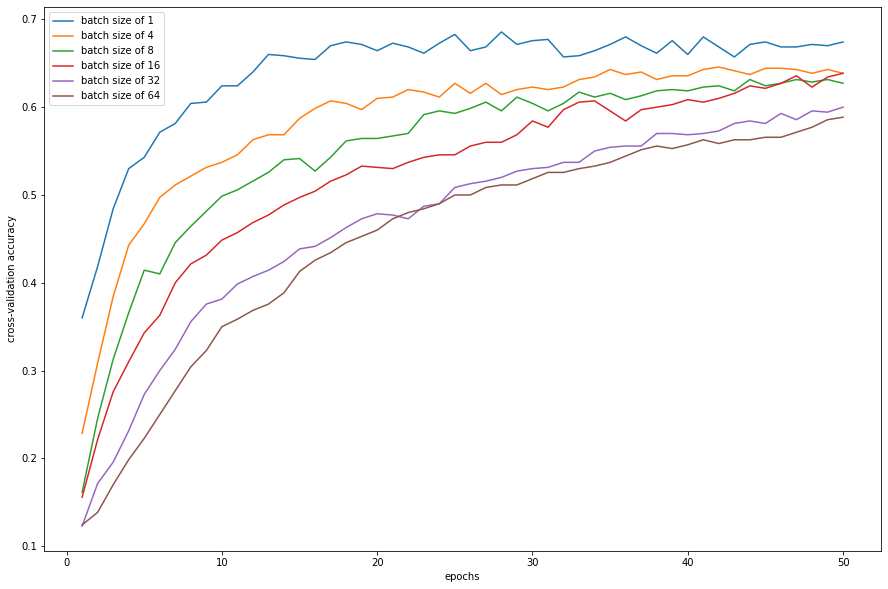

In [31]:


epoch_list=[(i+1) for i in range(epochs)]
plt.figure(figsize = (15,10))
plt.xlabel('epochs')
plt.ylabel('cross-validation accuracy')
for index in range(len(batch_sizes)):
  batch_size=batch_sizes[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.plot(epoch_list, mean_accuracy_list, label = 'batch size of '+str(batch_sizes[index]))
  plt.legend(loc='upper left')
plt.show()

  



---



In the cell below, we find the list of mean epoch times for different batch sizes over 3 fold cross validation and then use this mean epoch times list to find out the median epoch time for the respective batch sizes



---



In [32]:


mean_epoch_times={}
median_epoch_times = {}

for batch_size in batch_sizes:
  mean_epoch_times[batch_size] = [0] * 50

for batch_size in batch_sizes:

  for key in epoch_times.keys():

    if(key[0]==batch_size):

      for epoch in range(50):
        mean_epoch_times[batch_size][epoch] += epoch_times[key][epoch]

for batch_size in batch_sizes:

  for epoch in range(50):
    mean_epoch_times[batch_size][epoch] = mean_epoch_times[batch_size][epoch]/2

for batch_size in mean_epoch_times.keys():
  median_epoch_times[batch_size] = float("{:.2f}".format(statistics.median(mean_epoch_times[batch_size])))

median_epoch_time_table=pd.DataFrame(median_epoch_times.items(),columns=['Batch_size','Median epoch time'])



#Question 2 b)



---



In the cell below, we display the table containing the median epoch times for the respective batch sizes



---



In [33]:


median_epoch_time_table.index = median_epoch_time_table.index + 1
median_epoch_time_table # pandas dataframe that holds the median epoch time for the various batch sizes



,Batch_size,Median epoch time
1,1,1.43
2,4,0.41
3,8,0.26
4,16,0.15
5,32,0.11
6,64,0.09


#Question 2 parts c) d) and e)



---



In the cell below, we create a parameter optimal_batch_size, that denotes the selected optimal batch size for the model. Then we build and train the model, with the optimal batch size, on the original train and test data, additionally we plot the train and test accuracies for the model with the optimal batch size



---



Model for optimal batch size  16
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


44/44 [==============================] - 1s 5ms/step - loss: 2.3557 - accuracy: 0.1571 - val_loss: 2.0566 - val_accuracy: 0.2433
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 2.0897 - accuracy: 0.2214 - val_loss: 1.8727 - val_accuracy: 0.3500
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 1.9018 - accuracy: 0.3043 - val_loss: 1.7568 - val_accuracy: 0.3933
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 1.7864 - accuracy: 0.3400 - val_loss: 1.6700 - val_accuracy: 0.4100
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 1.7153 - accuracy: 0.3571 - val_loss: 1.6026 - val_accuracy: 0.4600
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 1.6491 - accuracy: 0.3957 - val_loss: 1.5468 - val_accuracy: 0.4867
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 1.5587 - accuracy: 0.4271 - val_loss: 1.4945 - val_accuracy: 0.5067
Epoch 8/50
44/44 [=============

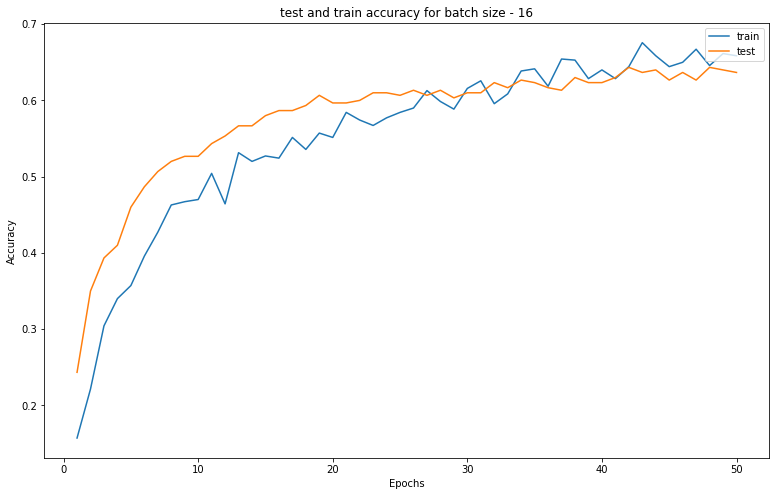

In [36]:


epoch_list=[(i+1) for i in range(epochs)] 

optimal_batch_size = 16 # denotes the selected optimal batch size for the model

print('Model for optimal batch size ',optimal_batch_size)

tf.keras.backend.clear_session()
model=build_model(total_classes,input_shape)
time_callback = TimeHistory()
history['optimal_batch_size_model'] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size,[time_callback])
print()
print()
plt.figure(figsize = (13,8))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('test and train accuracy for batch size - '+str(optimal_batch_size))
plt.plot(epoch_list,history['optimal_batch_size_model'].history['accuracy'],label='train accuracy')
plt.plot(epoch_list,history['optimal_batch_size_model'].history['val_accuracy'],label='test accuracy')
plt.legend(['train','test'] , loc='upper right')



#Question 3


In the cell below, we create models for different hidden-layer neurons over 3 fold cross validation

In [38]:


hidden_layer_neuron_list=[8, 16, 32, 64] # denotes the search space for the total number of neurons in the hidden layer as given in the assignment handout

k_fold = 1

for train,test in kf.split(X_train):

  X_train_cross_validation , X_test_cross_validation = X_train[train] , X_train[test]
  y_train_cross_validation , y_test_cross_validation = y_train[train] , y_train[test]

  for hidden_layer_neurons in hidden_layer_neuron_list:

    print()
    print('Model for ',hidden_layer_neurons, ' neurons and fold ',k_fold)
    print()
    print()
    tf.keras.backend.clear_session()
    model=build_model(total_classes,input_shape,hidden_layer_neurons)
    history[(hidden_layer_neurons,k_fold)] = train_model(model,epochs,X_train_cross_validation,y_train_cross_validation,X_test_cross_validation,y_test_cross_validation,optimal_batch_size,[time_callback])
    print()
    print()
  k_fold+=1




Model for  8  neurons and fold  1


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


30/30 [==============================] - 0s 6ms/step - loss: 2.4558 - accuracy: 0.1223 - val_loss: 2.3152 - val_accuracy: 0.1410
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 2.2589 - accuracy: 0.1931 - val_loss: 2.2029 - val_accuracy: 0.1795
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 2.1906 - accuracy: 0.1974 - val_loss: 2.1376 - val_accuracy: 0.2350
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 2.1562 - accuracy: 0.2210 - val_loss: 2.0764 - val_accuracy: 0.2521
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 2.1117 - accuracy: 0.2446 - val_loss: 2.0178 - val_accuracy: 0.2949
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 1.9881 - accuracy: 0.2961 - val_loss: 1.9730 - val_accuracy: 0.3120
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 1.9652 - accuracy: 0.2833 - val_loss: 1.9269 - val_accuracy: 0.3504
Epoch 8/50
30/30 [=============



---



In the cell below, we find the mean cross validation accuracies for different hidden layer neurons over 3 fold cross-validation



---



In [39]:


mean_cross_validation_accuracies=[]

for hidden_layer_neurons in hidden_layer_neuron_list:

  temp=[]
  for key in history.keys():

    if(key[0]==hidden_layer_neurons):
      temp.append(history[key].history['val_accuracy'])

  mean_accuracy=[0]*epochs

  for element in temp:

    for epoch in range(epochs):
      mean_accuracy[epoch]+=element[epoch]

  for epoch in range(epochs):
    mean_accuracy[epoch]=mean_accuracy[epoch]/n_splits
    
  mean_cross_validation_accuracies.append(mean_accuracy)



#Question 3 a)

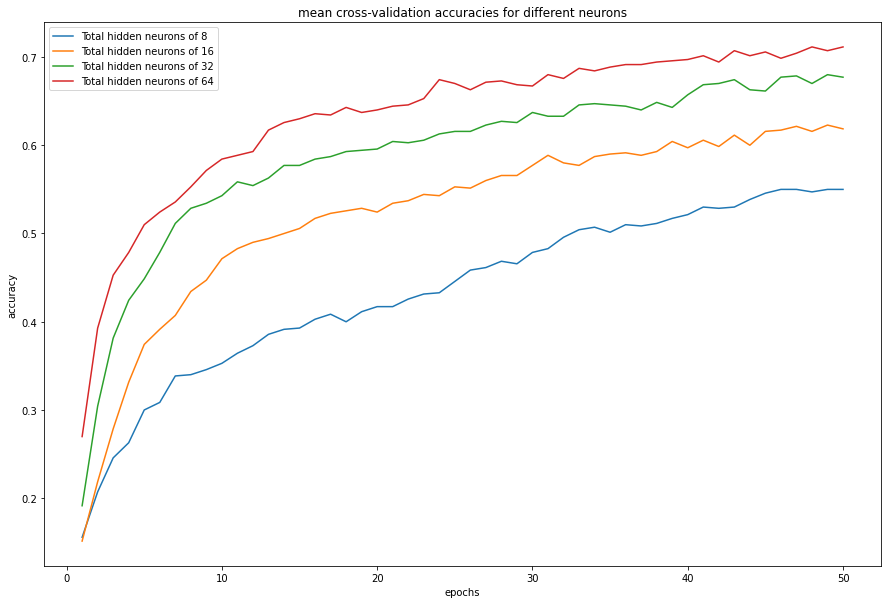

In [43]:


print()
print()
plt.figure(figsize = (15,10))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('mean cross-validation accuracies for different neurons')

for index in range(len(hidden_layer_neuron_list)):
  hidden_layer_neurons=hidden_layer_neuron_list[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.plot(epoch_list, mean_accuracy_list, label = 'Total hidden neurons of '+str(hidden_layer_neuron_list[index]))
  plt.legend()
plt.show()
print()
print()



#Question 3 b), c) and d)



---



In the cell below, we create a variable optimal_neurons that denotes the selected optimal number of hidden layer neurons. Then we train a model with the optimal hidden layer neurons on the original train data and test it on the test data and plot the corresponding train and test accuracies.



---





Model for optimal neurons  64


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


44/44 [==============================] - 1s 5ms/step - loss: 2.2638 - accuracy: 0.1743 - val_loss: 1.8290 - val_accuracy: 0.3533
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 1.7364 - accuracy: 0.3929 - val_loss: 1.5959 - val_accuracy: 0.4300
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 1.4969 - accuracy: 0.4671 - val_loss: 1.4447 - val_accuracy: 0.4967
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 1.3827 - accuracy: 0.5214 - val_loss: 1.3463 - val_accuracy: 0.5533
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 1.2520 - accuracy: 0.5557 - val_loss: 1.2696 - val_accuracy: 0.5700
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 1.1945 - accuracy: 0.5857 - val_loss: 1.2042 - val_accuracy: 0.6167
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 1.1014 - accuracy: 0.6329 - val_loss: 1.1529 - val_accuracy: 0.6133
Epoch 8/50
44/44 [=============

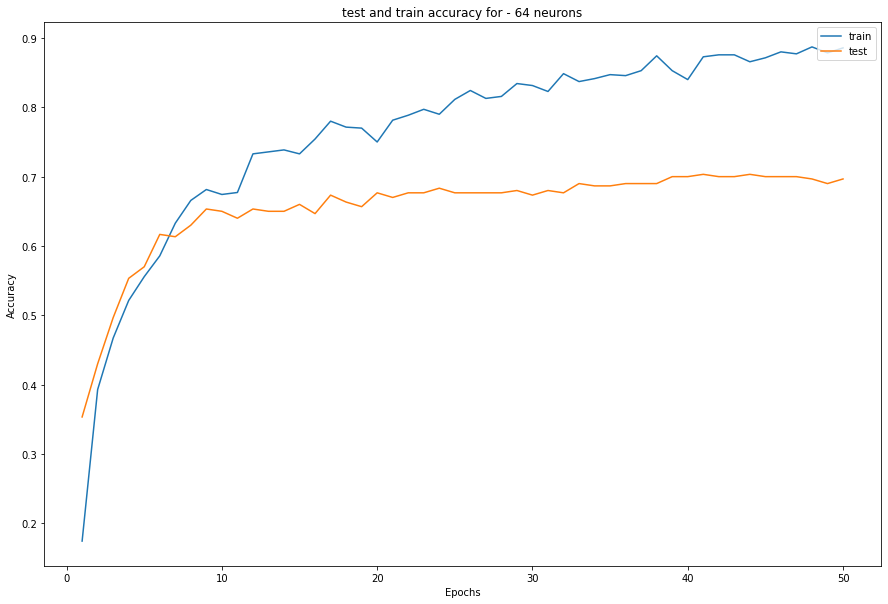

In [51]:


print()
print()
plt.figure(figsize = (15,10))
optimal_neurons = 64
print('Model for optimal neurons ',optimal_neurons)
print()
print()
tf.keras.backend.clear_session()
model=build_model(total_classes,input_shape,optimal_neurons)
history['optimal_neuron_model'] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size)
print()
print()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('test and train accuracy for - '+str(optimal_neurons)+' neurons')
plt.plot(epoch_list,history['optimal_neuron_model'].history['accuracy'],label='train accuracy')
plt.plot(epoch_list,history['optimal_neuron_model'].history['val_accuracy'],label='test accuracy')
plt.legend(['train','test'] , loc='upper right')
print()
print()



#Question-4 a) and b)



---



In the cell below, we train the model with 2 hidden layers and a batch size of 1 on the orignal train data and test it on the original test data




---



In [49]:


print(' Model with 2 hidden layers ')
print()
total_classes=10
image_shape=X_train[0].shape
hidden_layers=2
history={}
batch_size=1
model=build_model(total_classes,image_shape,optimal_neurons,hidden_layers)
history['question-4']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)
print()



 Model with 2 hidden layers 

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


700/700 [==============================] - 32s 2ms/step - loss: 1.8544 - accuracy: 0.3543 - val_loss: 1.4320 - val_accuracy: 0.5067
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.3799 - accuracy: 0.4971 - val_loss: 1.2178 - val_accuracy: 0.5567
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.2163 - accuracy: 0.5414 - val_loss: 1.1061 - val_accuracy: 0.5800
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 1.0534 - accuracy: 0.6071 - val_loss: 1.0620 - val_accuracy: 0.5867
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 0.9834 - accuracy: 0.6686 - val_loss: 1.0675 - val_accuracy: 0.6400
Epoch 6/50
700/700 [==============================] - 1s 2ms/step - loss: 0.9159 - accuracy: 0.6829 - val_loss: 0.9973 - val_accuracy: 0.6333
Epoch 7/50
700/700 [==============================] - 1s 2ms/step - loss: 0.8670 - accuracy: 0.6829 - val_loss: 0.9772 - val_accuracy: 0.6633
Epoch 8/50
700/7

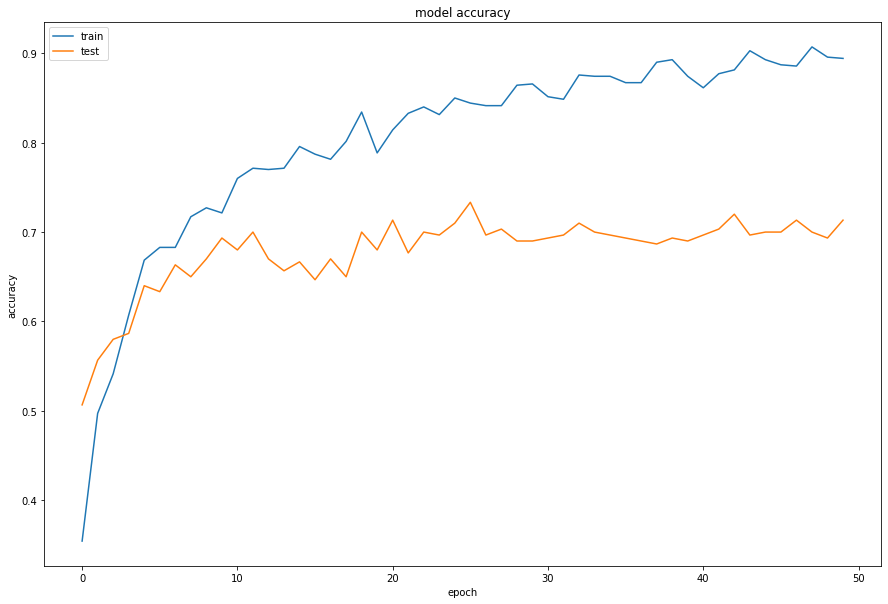

In [50]:


print()
print()
plt.figure(figsize = (15,10))
plt.plot(history['question-4'].history['accuracy'])
plt.plot(history['question-4'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
print()



#Question-5 part a), b) and c)




---



In the cell below, we build a model by excluding the dropout layers 



---



In [52]:


print()
print(' Model without dropout layer ')
print()
print()
history={}
model=build_model(10,X_train[0].shape)
hidden_layer_neurons=16
hidden_layers=1
epochs=50
total_classes=10
need_drop_out=False # denotes the exclusion of dropout layers
input_shape=X_train[0].shape
batch_size=1
model=build_model(total_classes,input_shape,hidden_layer_neurons,hidden_layers,need_drop_out)
history={}
history['question-5']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)
print()
print()




 Model without dropout layer 


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


700/700 [==============================] - 2s 2ms/step - loss: 2.0015 - accuracy: 0.3257 - val_loss: 1.6678 - val_accuracy: 0.3967
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.3510 - accuracy: 0.5329 - val_loss: 1.4019 - val_accuracy: 0.4867
Epoch 3/50
700/700 [==============================] - 1s 1ms/step - loss: 1.1065 - accuracy: 0.6271 - val_loss: 1.2535 - val_accuracy: 0.5433
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 0.9586 - accuracy: 0.6700 - val_loss: 1.1864 - val_accuracy: 0.5667
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 0.8533 - accuracy: 0.7000 - val_loss: 1.1496 - val_accuracy: 0.5700
Epoch 6/50
700/700 [==============================] - 1s 2ms/step - loss: 0.7737 - accuracy: 0.7300 - val_loss: 1.1287 - val_accuracy: 0.5833
Epoch 7/50
700/700 [==============================] - 1s 2ms/step - loss: 0.7089 - accuracy: 0.7743 - val_loss: 1.0932 - val_accuracy: 0.5900
Epoch 8/50
700/70

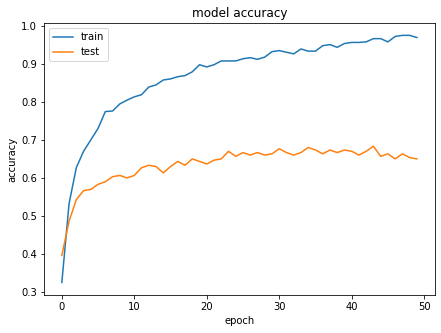

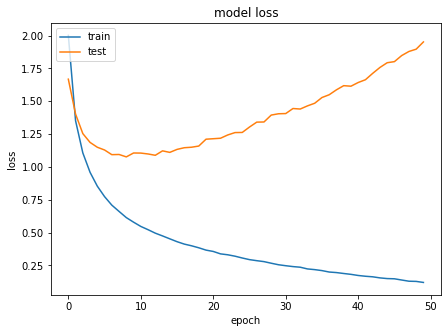

In [56]:

print()
print()
plt.figure(figsize = (7,5))
plt.plot(history['question-5'].history['accuracy'])
plt.plot(history['question-5'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
print()
print()
plt.figure(figsize = (7,5))
plt.plot(history['question-5'].history['loss'])
plt.plot(history['question-5'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
print()

